In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

#### 为了说明矢量化为什么如此重要，我们考虑对向量相加的两种方法。 我们实例化两个全为1的10000维向量。 在一种方法中，我们将使用Python的for循环遍历向量； 在另一种方法中，我们将依赖对+的调用。

In [2]:
n=10000
a=torch.ones([n])
b=torch.ones([n])

In [3]:
# 定义一个计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

#### 首先，我们使用for循环，每次执行一位的加法。

In [5]:
a,b

(tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [4]:
c=torch.zeros(n)
c

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [6]:
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.04663 sec'

#### 或者，我们使用重载的+运算符来计算按元素的和

In [7]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00024 sec'

In [8]:
#### 定义一个函数计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

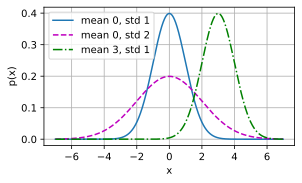

In [9]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

### 生成数据集

#### 下面的代码生成合成数据集

In [13]:
x1=torch.normal(0,1,(10,4))
x1

tensor([[-0.3754, -0.2858, -0.8695, -0.3682],
        [ 0.0412,  1.8929, -1.3865,  1.1107],
        [-0.4271,  0.9607, -0.4558,  1.0994],
        [-1.2862, -0.2884, -0.7133,  1.3366],
        [ 0.9814,  2.6486, -0.6759, -0.8450],
        [ 0.5352, -0.0255,  0.2831,  0.0394],
        [-0.5180, -0.6250, -1.2886,  0.4846],
        [-0.3498,  1.4479,  0.5417,  0.9531],
        [-0.9615,  1.0899,  0.2184, -0.8369],
        [-0.5280, -0.4455, -0.1919,  0.8525]])

In [16]:
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w))) # 生成num_examples行,len(w)列的X数据
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [17]:
features,labels

(tensor([[ 0.5858, -0.6764],
         [ 0.6184, -1.3300],
         [-0.6773, -0.0744],
         ...,
         [ 3.3384,  0.5942],
         [ 0.6210, -1.1297],
         [-1.3509, -0.6045]]),
 tensor([[ 7.6640e+00],
         [ 9.9576e+00],
         [ 3.1162e+00],
         [ 1.6451e+00],
         [ 2.8060e+00],
         [ 5.0288e+00],
         [-9.0712e-01],
         [-3.0999e-01],
         [ 7.7956e+00],
         [ 1.1963e+00],
         [ 9.0130e+00],
         [ 6.9602e+00],
         [ 3.3531e+00],
         [ 3.4522e+00],
         [-7.3927e-01],
         [ 1.3224e+01],
         [-1.3335e-01],
         [ 1.7953e+00],
         [ 7.4579e+00],
         [ 5.8929e+00],
         [-4.5859e-01],
         [ 7.6996e+00],
         [ 6.1334e+00],
         [ 1.1098e+01],
         [ 5.4872e+00],
         [ 1.6403e+00],
         [ 4.1928e+00],
         [ 8.5340e+00],
         [ 5.4436e+00],
         [ 8.3337e+00],
         [ 1.8583e-01],
         [ 3.4991e+00],
         [ 6.2664e+00],
         [ 1.3121e

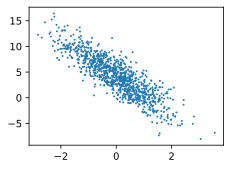

In [18]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

#### 回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

In [21]:
#在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，
# 生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
import random
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [22]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7526, -0.4787],
        [-0.2567,  0.2883],
        [ 0.3186, -0.5187],
        [ 1.6268, -0.9807],
        [ 0.6982, -1.3575],
        [ 0.8900,  0.4815],
        [-0.8677,  0.3339],
        [ 0.9834,  1.4005],
        [ 0.9076,  1.2449],
        [ 3.4575, -0.1508]]) 
 tensor([[ 4.3180],
        [ 2.7162],
        [ 6.6007],
        [10.7830],
        [10.2087],
        [ 4.3338],
        [ 1.3250],
        [ 1.4009],
        [ 1.7906],
        [11.6252]])


### 初始化模型参数

In [23]:
# 在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。
# 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### 在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。

In [24]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [25]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [26]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039803
epoch 2, loss 0.000153
epoch 3, loss 0.000053


In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0008, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现

In [29]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
# 我们首先生成数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [30]:
# 读取数据集
# 我们可以调用框架中现有的API来读取数据。 我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。 
# 此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [31]:
next(iter(data_iter)) #这里我们使用iter构造Python迭代器，并使用next从迭代器中获取第一项

[tensor([[ 0.3711,  0.4533],
         [-0.0180,  1.2011],
         [-1.9522,  0.0068],
         [-1.8168,  0.5790],
         [-0.2527, -1.1251],
         [ 0.0782,  1.0259],
         [ 0.0652, -0.0941],
         [-2.0048,  0.8360],
         [-0.0395,  1.7417],
         [-0.1314,  0.2190]]),
 tensor([[ 3.3969],
         [ 0.0675],
         [ 0.2578],
         [-1.4016],
         [ 7.5267],
         [ 0.8685],
         [ 4.6513],
         [-2.6506],
         [-1.8095],
         [ 3.1900]])]

In [32]:
# nn是神经网络的缩写
from torch import nn
 
net = nn.Sequential(nn.Linear(2, 1)) # 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。

In [33]:
# 正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。 我们通过net[0]选择网络中的第一个图层， 
# 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [34]:
loss = nn.MSELoss() # 损失函数

In [35]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03) # 优化算法 net.parameters()从我们给的模型中获取参数

In [36]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000147
epoch 2, loss 0.000101
epoch 3, loss 0.000101


In [37]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-3.6144e-04, -2.8849e-05])
b的估计误差： tensor([0.0003])
